In [24]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
import datetime
import lightgbm as lgb
import os
import time

In [2]:
# read dataset
data = pd.read_csv("dataset/preprocessed.csv")
data_npWNan = data.iloc[:, :].values
data_np = data_npWNan[data_npWNan[:,-1]!= -1 ]

In [3]:
# Separate input features and target
feature = data_np[:, :-1]
target = data_np[:, -1]
target -= 1

In [4]:
# split train and test part
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 0)

In [5]:
# print distribution before re-sampling
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 62846  69846 109216 147032 220735]]


Text(0.5, 1.0, 'Unbalanced Data Distribution')

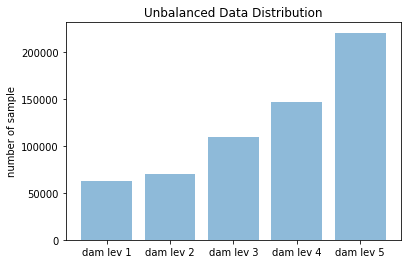

In [6]:
# plot distribution before re-sampling
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('Unbalanced Data Distribution')

In [7]:
# apply re-sampling
sm = SMOTETomek(random_state = 27, n_jobs = -1)
X_train, y_train = sm.fit_sample(X_train, y_train)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [8]:
# print distribution after re-sampling
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [204152 195863 187569 181912 186017]]


Text(0.5, 1.0, 'After Re-sampling Data Distribution')

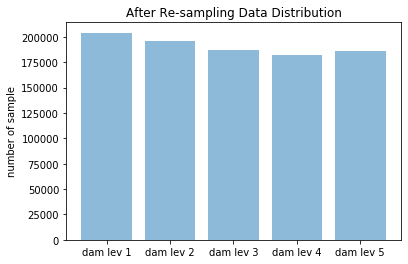

In [9]:
# plot distribution after re-sampling
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('After Re-sampling Data Distribution')

In [10]:
# apply feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
from sklearn.model_selection import GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs = 1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    return fitted_model, pred

In [12]:
# calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

In [13]:
# test algorithm with different settings and choose best one
import datetime
a = datetime.datetime.now().replace(microsecond=0)

model = lgb.LGBMClassifier(n_jobs = -1)
param_grid = {
    'min_split_gain': [0.3, 0.4, 0.5],
    'learning_rate' : [0.5],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'], 
    'n_estimators': [500],
    'colsample_bytree': [1.0],
    'max_depth': [40],
    'num_leaves': [50],
    'reg_alpha': [1.1],
    'reg_lambda': [1.1],
    'subsample': [0.5],
    'subsample_freq': [1],
    'subsample_for_bin' : [100],
}
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv = 2, scoring_fit='accuracy')

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.5, max_depth=40, min_split_gain=0.3, n_estimators=500, num_leaves=50, objective=multiclass, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5, subsample_for_bin=100, subsample_freq=1 
[CV]  boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.5, max_depth=40, min_split_gain=0.3, n_estimators=500, num_leaves=50, objective=multiclass, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5, subsample_for_bin=100, subsample_freq=1, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.5, max_depth=40, min_split_gain=0.3, n_estimators=500, num_leaves=50, objective=multiclass, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5, subsample_for_bin=100, subsample_freq=1 
[CV]  boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.5, max_depth=40, min_split_gain=0.3, n_estimators=500, num_leaves=50, objective=multiclass, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/emreunel/anaconda3/envs

In [14]:
# print best accuracy
print(model.best_score_)

0.5209630847513326


In [15]:
# print best parameters
print(model.best_params_)

{'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 40, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'objective': 'multiclass', 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.5, 'subsample_for_bin': 100, 'subsample_freq': 1}


In [16]:
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

0:10:02


In [17]:
params = model.best_params_

In [18]:
model = lgb.LGBMClassifier(n_jobs = -1,
                           boosting_type = params['boosting_type'],
                           colsample_bytree = params['colsample_bytree'],
                           learning_rate = params['learning_rate'],
                           max_depth = params['max_depth'],
                           min_split_gain = params['min_split_gain'],
                           # n_estimators = params['n_estimators'],
                           n_estimators = 3500,
                           num_leaves = params['num_leaves'],
                           objective = params['objective'],
                           reg_alpha = params['reg_alpha'],
                           reg_lambda = params['reg_lambda'],
                           subsample = params['subsample'],
                           subsample_for_bin = params['subsample_for_bin'],
                           subsample_freq = params['subsample_freq'],
                           )

In [19]:
model.fit(X_train, y_train)
b = datetime.datetime.now().replace(microsecond=0)

In [20]:
#Prediction
y_pred=model.predict(X_test)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
# print results
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print("Accuracy: \t", accuracy_score(y_test, y_pred))
print("F1 Score: \t", f1_score(y_test, y_pred, average = 'macro'))
print("Precision:\t", precision_score(y_test, y_pred, average = 'macro'))
print("Recall:   \t", recall_score(y_test, y_pred, average = 'macro'))

Accuracy: 	 0.5215753941437747
F1 Score: 	 0.4805193326913647
Precision:	 0.4765297481313433
Recall:   	 0.48739635776867807


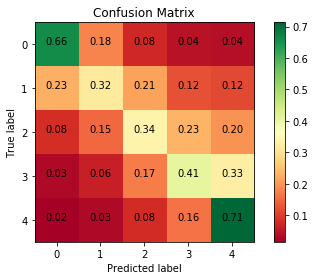

array([[0.66109337, 0.17984846, 0.07539608, 0.04402279, 0.0396393 ],
       [0.2301993 , 0.31841939, 0.21182011, 0.12451898, 0.11504221],
       [0.08295338, 0.14980144, 0.33795411, 0.23367407, 0.195617  ],
       [0.03066935, 0.06381071, 0.17219928, 0.40628056, 0.3270401 ],
       [0.01550035, 0.03058276, 0.07962785, 0.16105468, 0.71323436]])

In [22]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
plt.show()
cm